<a href="https://colab.research.google.com/github/esmanursaracbasi/Movie-Review-Analysis-with-Deep-Learning/blob/master/movies_reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import io
import re
import random

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# IMPORTING DATA
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1EYglzaarO-KtF_qstCup1gLg4GvTQFzP"})   # replace the id with id of file you want to access
downloaded.GetContentFile('IMDB Dataset.csv')

In [ ]:
f = open('IMDB Dataset.csv', encoding='utf-8')

In [ ]:
movie_reviews = pd.read_csv(f)

In [ ]:
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# PREPROCESSING OF TEXT COLUMN

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
# makes text column preprocessed
reviews = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [ ]:
# makes labels as 0 and 1 
y = movie_reviews['sentiment']
y = list(map(lambda x: 1 if x=="positive" else 0, y))

In [ ]:
print(reviews[0])
print(y[0])

One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty pictures

In [ ]:
# DATA IS READY TO SPLIT INTO TEST AND TRAIN.
df = pd.DataFrame(list(zip(reviews, y)), columns =['sentence', 'label']) 
df.head()

,sentence,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was wonderful way to spend time...,1
3,Basically there a family where little boy Jake...,0
4,Petter Mattei Love in the Time of Money is vis...,1


In [ ]:
from sklearn.model_selection import train_test_split

sentences = df['sentence'].values   # getting sentence column values
y         = df['label'].values      # getting label column values 

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [ ]:
# COUNT VECTORIZER TO APPLY LOGISTIC REGRESSION

from sklearn.feature_extraction.text import CountVectorizer

#We apply fit on the training dataset and use the transform method on both - the training dataset and the test dataset. 
#Thus the training as well as the test dataset are then transformed(scaled) using the model parameters that were learnt on applying the fit method the training dataset.
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<37500x89932 sparse matrix of type '<class 'numpy.int64'>'
	with 5059373 stored elements in Compressed Sparse Row format>

In [ ]:
print(X_train.shape) 

(37500, 89932)


In [ ]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.88416


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LOGISTIC REGRESSION Accuracy: 0.88

In [ ]:
!pip install keras

In [ ]:
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [ ]:
# FIRST MODEL WITH KERAS FOR BASE 
input_dim = X_train.shape[1]  # Number of features = 1714

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) # output = activation(dot(input, kernel) + bias)
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) # this loss funcition is used for binary classifications.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                899330    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 899,341
Trainable params: 899,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                     epochs=3,
                     verbose=0,
                     validation_data=(X_test, y_test),
                     batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9995
Testing Accuracy:  0.8806


FIRST MODEL WITH KERAS FOR BASE Testing Accuracy:  0.88

In [ ]:
# REDUCING DIMENSOIN OF INPUT MATRIX FROM (37500, 89932) TO  (37500, 1000)
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
X_train = svd.fit_transform(X_train)

In [ ]:
print(X_train.shape)

(37500, 1000)


In [ ]:
X_test = svd.transform(X_test)

In [ ]:
print(X_test.shape)

(12500, 1000)


In [ ]:
# TRYING THE SAME CODE WITH REDUCED MATRIX.
input_dim = X_train.shape[1]  # Number of features = 1714

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) # output = activation(dot(input, kernel) + bias)
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) # this loss funcition is used for binary classifications.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                10010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                     epochs=10,
                     verbose=0,
                     validation_data=(X_test, y_test),
                     batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9427
Testing Accuracy:  0.8597


WITH THE REDUCED MATRIX Testing Accuracy:  0.85

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
# TOKENIZER IMPLEMENTATION
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I really really wanted to see this movie and waited for months to get it through our Blockbuster Total Access account When it showed up in our mailbox threw it straight into the DVD player was very sadly disappointed which in turn made me mad ll give any movie chance even if want to walk out of the theater press stop watched it all the way through but didn get anything from it but frustration The acting was very very good but that was about it Nothing is explained while we understand that Mathieu becomes depressed and lands in psych ward of some kind we re never given insight to his downfall While we understand that he and Cedric break up again we don see it happen or WHY it happened During an interview with Mathieu doctor Cedric reveals that he cheated on him once but it was no big deal expected to see this in flashbacks but no nothing We also gets the hints that Cedric was the one to bring Mat to the hospital but AGAIN we don see it know some movies are take it as it is basis but thi

In [ ]:
# PADDING
from keras.preprocessing.sequence import pad_sequences

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
print(X_train[0, :])

[   9 1342  684 1122   19   37    7  276 2745   15  915    1 3145    2
 2423    3   75 2354    8 2467    4  622  358   48 3625    6  493   89
   92   78    1    3  183  395  767  442   22    2 4807 3204   33  284
   61    1  362   21 2186   13  779    2 2424 4543  117   89   97  923
    6 1146  934    3  195  287  156    2  404   92    4 1167   15 2088
    7 1208  460 1875    6 3040    7    1  168   11  336  860   48   68
    6 1045 2538   15 3786    2 2311    4   89  183 1881  577  891 3302
    9  119   11  183  395 1538  183  120 1002    4 3092    1   16   78
  222   16   13   89 3008  200   18    1  280    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

APPYLING WORD EMBEDDING METHOD WITH GLOVE WORD EMBEDDINGS.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-06-03 14:21:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-03 14:21:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-03 14:21:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file glove
downloaded = drive.CreateFile({'id':"1_eBtwK8_HeZJmD6zXVLmKNTFtXHx2TQx"})   # replace the id with id of file you want to access
downloaded.GetContentFile('glove.6B.100d.txt')

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
      for line in f:
        word, *vector = line.split()
        if word in word_index:
            idx = word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.763381095832546

In [ ]:
# trainable=False

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 50)           4497950   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 4,498,471
Trainable params: 521
Non-trainable params: 4,497,950
_________________________________________________________________


Training Accuracy: 0.6518
Testing Accuracy:  0.6493


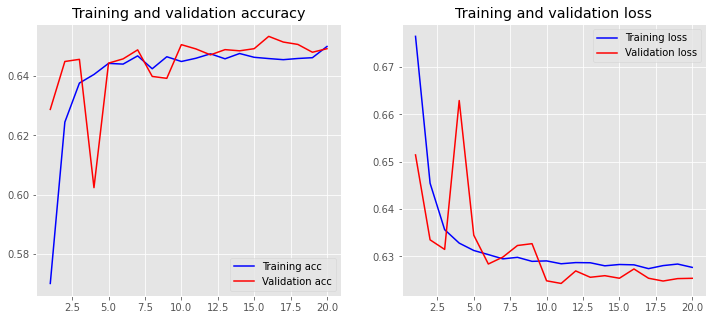

In [ ]:
history1 = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history1)

In [ ]:
# trainable=True

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           4497950   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 4,498,471
Trainable params: 4,498,471
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9670
Testing Accuracy:  0.8313


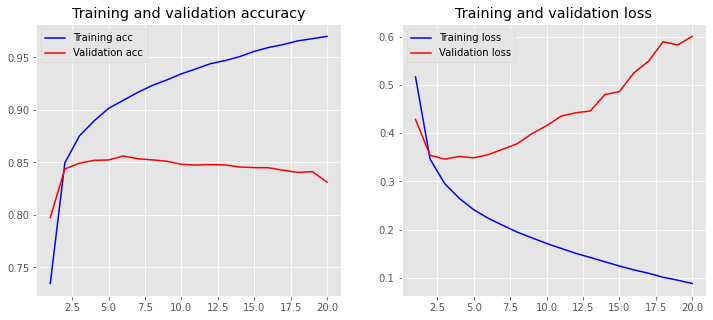

In [ ]:
# WITH 20 EPOCHS 
history2 = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history2)

with 20 epochs Testing Accuracy:  0.83

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 0.9515
Testing Accuracy:  0.8493


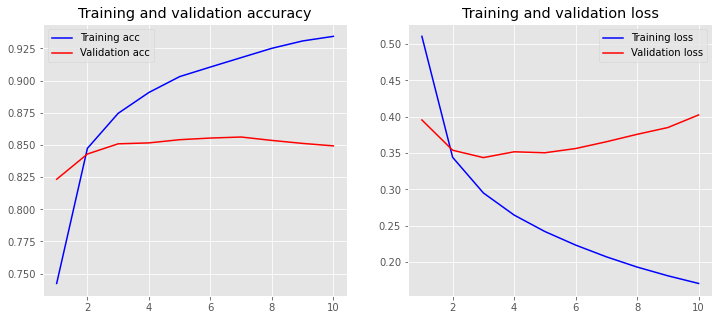

In [ ]:
# running 10 epochs instead of 20 epochs

history3 = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history3)

with 10 epoch Testing Accuracy:  0.84